In [1]:
# ------------------------------------------------------------
# 0. Imports & helpers
# ------------------------------------------------------------
import torch
import torch.nn.functional as F
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"

We will first generate a synthetic one-hot dataset. This is a categorical dataset of 1024 data points, where each point falls in to one of 32 categories. So we use a one-hot encoding, resulting in a matrix of 1024x32.
e.g. [0, 0, 0, 1, 0, ..., 0]  ← means class index 3



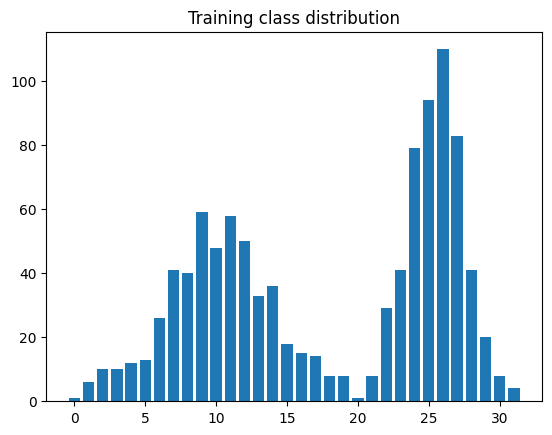

In [3]:
# ------------------------------------------------------------
# Generate Synthetic one-hot data
# ------------------------------------------------------------
n_samples    = 1_024         # Number of samples (rows) we want in our dataset
n_classes    = 32            # Each sample will belong to one of 32 categories
latent_dim   = 1             # We want the VAE to learn a 1D latent space
hidden_dim   = 16            # Size of the hidden layer in the neural network (not used yet here)

# Two-component Gaussian mixture, then histogram-bin to one-hot. This makes 2 gaussians as a toy set
z_true          = np.random.choice([0, 1], size=n_samples) # this is so we get two blobs in the distribution
x_continuous    = ((z_true + 1) % 2) * np.random.normal(-1, 0.5, n_samples) \
                  +  z_true            * np.random.normal(+1, 0.25, n_samples)

# gets edges of bins so that we can pass in the set and get what index bin it falls to
bins            = np.histogram_bin_edges(x_continuous, bins=n_classes)

# figures out which bin each datapoint falls into, returns index of that bin, in form of one-hot encoding
digitized_values = np.digitize(x_continuous, bins) - 1
digitized_values = np.clip(digitized_values, 0, n_classes - 1)
one_hot = np.eye(n_classes)[digitized_values]
data = torch.tensor(one_hot, dtype=torch.float32).to(device) # np array to pytorch tensor object, [1024, 32]

plt.bar(np.arange(n_classes), one_hot.sum(0))
plt.title("Training class distribution"); plt.show()

Encoder: Input is flattened one-hot vector (32 dimensions if we have 32 classes).
[0, 0, 1, 0, ..., 0]  ← this means “class 2”

MLP maps out tp mu and log sigma of the latent Gaussian.

Decoder: takes in 'z', which is small dense latent vector, and tries to rebuild the original input. MLP maps latent variable z back to logits over one-hot classes. The output is a vector of raw scores, one for each original class (called logits),
e.g.
Decoder output (logits): [2.1, -0.5, 0.3, ..., 1.2]  ← length 32
(these are not probabilties yet, just scores before applying softmax)

If latent space has dimension 1, then e.g.
mu = tensor([0.3])       # center of latent space Gaussian
logvar = tensor([-0.5])  # log variance (controls spread)

In [18]:
# ------------------------------------------------------------
# 2. Encoder & decoder (plain nn.Sequential for brevity)
# ------------------------------------------------------------

# encoder input is 32D one hot vector
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_classes, hidden_dim), nn.ReLU(), # input is 32D one hot
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2) # 2 bc μ and σ̂
        )

    # x is passed through network
    def forward(self, x):
        out         = self.net(x) # this is the NN defined in __init__
        mu, log_sig = out[:, :latent_dim], out[:, latent_dim:] # output shape is [batch_size,2]
        # softplus (kinda like reLU, but smoothed) to keep σ > 0
        sigma       = F.softplus(log_sig)
        return mu, sigma


# takes latent vector z (sampled from gaussian defined by encoder) and reconstructs input (a one-hot vector of 32 classes)
# given z, how likely is each of the 32 classes
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, n_classes) # logits → softmax later
        )

        # Logits are the raw scores output by a model before turning them into probabilities. [batch_size,32]
        # each number is a score for a class
        #They’re the input to the softmax function — which turns them into a proper probability distribution (normaliztaion, using exponential terms to exagerate th winner, useful for classification)
    def forward(self, z, return_logits=False):
        logits = self.net(z)
        if return_logits:
            return logits
        return F.softmax(logits, dim=-1)


Reconstruction loss - CrossEntropyLoss between input and decoded logits (since inputs are one-hot)

If input is a one-hot class (smiles class or digits class), then cross entropy loss is used because it compares what class you actually gav and what class the model predicts.

If input is continuous (like image pixel), then use MSE/L2 loss - this is more normal

KL loss - analytically computed KL between the encoded distribution and standard normal. You can scale the KL term with a beta (β-VAE) to explore how stronger regularization shapes the latent space.

In [33]:
# ------------------------------------------------------------
# 3. VAE loss (negative ELBO) and training utilities
# ------------------------------------------------------------

# instantiate encoder and decoder NNs
encoder, decoder = Encoder().to(device), Decoder().to(device)

# combined parameters for both models to one list, single optimizer that updates
# all parameters for both encoder and decoder
opt              = optim.Adam(list(encoder.parameters()) +
                              list(decoder.parameters()), lr=1e-1)

# loss for reconstruction and KL divergence
def vae_loss(x, beta=1.0):

    mu, sigma = encoder(x)

    # re-parameterisation trick - this makes the process differentiable
    # sample eps ~ N(0, 1), then z = mu + sigma * eps
    eps       = torch.randn_like(mu)
    z_sample  = mu + eps * sigma

    # Get raw decoder outputs (logits)
    logits = decoder(z_sample, return_logits=True)

    # Convert one-hot back to class labels
    labels = x.argmax(dim=1)

    # Built-in cross entropy (per sample)
    recon_ll = F.cross_entropy(logits, labels, reduction='none')
     # −log pθ(x|z), cross entropy term
    # measures how well decoder reconstructs x
    # recon_ll is negative log likelihood

    # KL[q(z|x) || N(0,1)]
    kl = -torch.log(sigma) + 0.5 * (sigma**2 + mu**2) - 0.5  # per-dim
    kl = kl.sum(dim=1)
    # this measures who the encoder's output distribution differes frmo a standard normal distribution
    # keeps the latent space nicely reguarlized

    total_loss = recon_ll + beta * kl
    return total_loss.mean(), recon_ll.mean(), kl.mean()

# Training loop ------------------------------------------------
loss_traj, recon_traj, kl_traj = [], [], []

for epoch in range(epochs):
    perm = torch.randperm(len(data))

    for i in range(0, len(data), batch_size):
        batch = data[perm[i:i+batch_size]]

        opt.zero_grad()
        loss, recon, kl = vae_loss(batch, beta=0.1)
        loss.backward()
        opt.step()

        # ✅ Log per-batch loss
        loss_traj.append(loss.item())
        recon_traj.append(recon.item())
        kl_traj.append(kl.item())



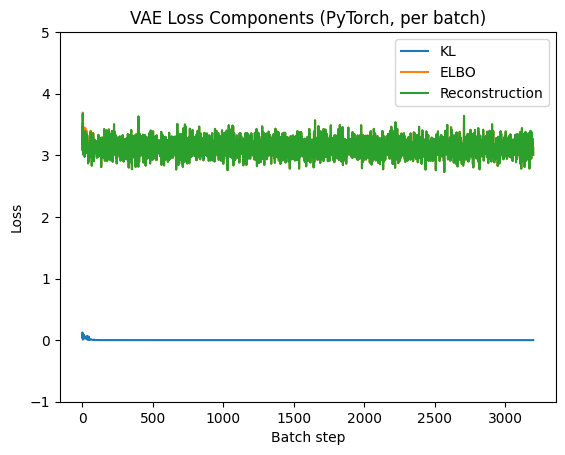

In [34]:
# ------------------------------------------------------------
# 4. Monitor ELBO components
# ------------------------------------------------------------
elbo = np.array(recon_traj) + np.array(kl_traj)


plt.plot(kl_traj, label="KL")
plt.plot(elbo, label="ELBO")
plt.plot(recon_traj, label="Reconstruction")


plt.xlabel("Batch step")
plt.ylabel("Loss")
plt.legend()
plt.ylim(-1, 5)
plt.title("VAE Loss Components (PyTorch, per batch)")
plt.show()


To get a specific point to decode, we sample from the Gaussian described by mu and logvar. But to allow training, we use a trick:



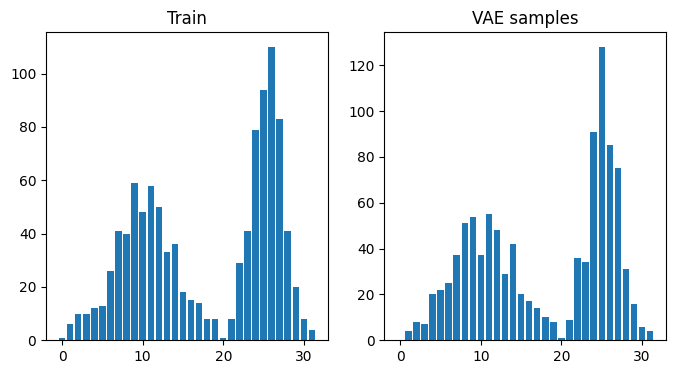

Average μ : -8.96831017167883e-44 Average σ : 1.0


In [35]:
# ------------------------------------------------------------
# 5. Evaluate the trained VAE
# ------------------------------------------------------------
@torch.no_grad()
def sample_vae(n=1_024):
    z   = torch.randn(n, latent_dim, device=device)
    px  = decoder(z)                 # categorical probs
    idx = torch.multinomial(px, num_samples=1).squeeze()
    one_hot = F.one_hot(idx, n_classes).float()
    return one_hot.cpu().numpy()

samples = sample_vae()
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].bar(np.arange(n_classes), one_hot.sum(0)); ax[0].set_title("Train")
ax[1].bar(np.arange(n_classes), samples.sum(0));  ax[1].set_title("VAE samples")
plt.show()

# Encoder statistics  (should approach N(0,1))
mu, sigma = encoder(data)
print("Average μ :", mu.mean().item(),  "Average σ :", sigma.mean().item())


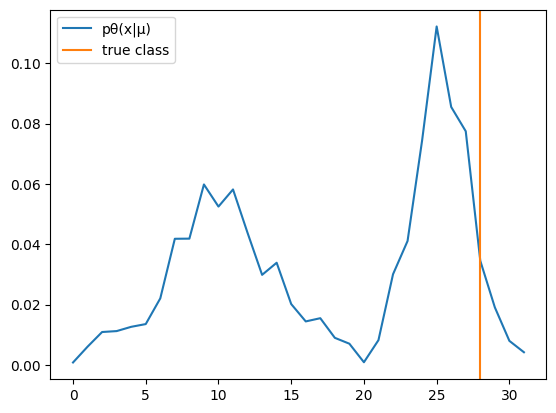

In [36]:
# ------------------------------------------------------------
# 6. Quick reconstruction sanity-check
# ------------------------------------------------------------
i   = 2
mu, sigma = encoder(data[i:i+1])
x_hat     = decoder(mu)             # use mean of q(z|x) for clarity
# Detach the tensor from the computational graph before converting it to a NumPy array
plt.plot(x_hat.squeeze().cpu().detach().numpy(), label="pθ(x|μ)")
plt.axvline(data[i].argmax().cpu(), color='C1', label="true class")
plt.legend(); plt.show()
